In [118]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image

In [1988]:
import selfsupmotion.zero_shot_pose as zsp
zsp.use_cupy = False
experiment = "../output"
embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [4432]:
idx=25139
points_2d, points_3d_query = zsp.get_points(info_df, idx)
points_2d_px_query = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
plane_center_query, plane_normal_query= zsp.get_plane(info_df, idx)

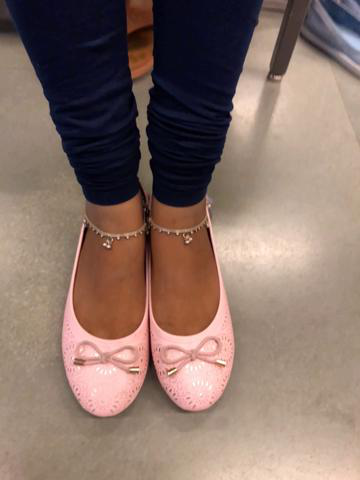

In [4433]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
query_im

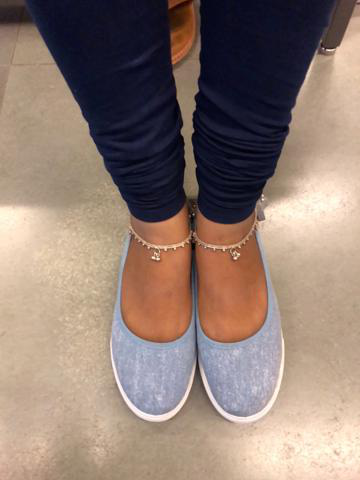

In [4434]:
match_idx, score = zsp.find_match_idx(idx, embeddings, train_embeddings,0, score=True)
res_im=Image.open(train_info_df.iloc[match_idx]["filepath_full"])
res_im

In [4435]:
points_2d, points_3d_result = zsp.get_points(train_info_df, match_idx)
plane_center_result, plane_normal_result = zsp.get_plane(train_info_df, match_idx)

camera = zsp.get_camera(info_df, idx)
intrinsics = zsp.get_intrinsics(camera)
intrinsics = zsp.scale_intrinsics(intrinsics, 0.25,0.25)
intrinsics

query_bbox = zsp.get_bbox(points_2d_px_query, 360, 480)
cx = (query_bbox[0] + query_bbox[2])/2
cy = (query_bbox[1] + query_bbox[3])/2
b = (cx - intrinsics[1,2])/intrinsics[1,1]
a = (cy - intrinsics[0,2])/intrinsics[0,0]
cx, cy, a, b, points_2d_px_query[0]


(200.33421277999878,
 293.3055639266968,
 0.1457968954138858,
 0.051519704070312235,
 array([186.70376301, 281.49381638]))

In [4436]:
box_rotation = zsp.rotation_matrix_from_vectors(plane_normal_query, plane_normal_result)
plane_normal_query, plane_normal_result, plane_center_query, plane_center_result
points_3d_axis = np.dot(points_3d_result-points_3d_result[0],box_rotation)+points_3d_result[0]


In [4437]:

#cx, cy = points_2d_px_query[0]

z=-points_3d_query[0][2]
#az = x, bz = y
point_on_center_line = np.array([a,b,-1])
point_on_center_line

def get_dist_from_plane(plane_normal, plane_center, point):
    plane = zsp.get_plane_equation_center_normal(plane_center, plane_normal)
    a, b, c, d = plane
    X,Y,Z = point
    return abs(a*X + b*Y + c*Z + d)/np.sqrt(a**2+b**2+c**2)
obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points_3d_result[0])
obj_radius


0.037976141994365484

In [4438]:
#obj_radius = get_dist_from_plane(plane_center_query, plane_normal_query, points_3d_query[0])
#obj_radius
obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points_3d_axis[0])
obj_radius

0.037976141994365484

In [4439]:

def intersect_plane_with_line(plane_normal, plane_center, point1, point0=np.array([0,0,0])):
    p0 = plane_center
    n = plane_normal
    l0 = point0 #Line start.
    l = point1 #Line end
    d = np.dot((p0-l0), n)/np.dot(l,n)
    intersect = l0 + d*l
    return intersect
offset = obj_radius * plane_normal_query
#offset = np.array([0,0,0])
new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
new_center, offset, points_3d_query[0], points_3d_result[0]


(array([ 0.05822295,  0.02057403, -0.39934285]),
 array([-0.02095835,  0.00281505,  0.03154378]),
 array([ 0.04667538,  0.00660874, -0.40347582]),
 array([ 0.05187403,  0.05556004, -0.397392  ]))

In [4440]:
get_dist_from_plane(plane_normal_query, plane_center_query, new_center)
points_3d_result_centered = points_3d_axis - points_3d_axis[0] + new_center
points_3d_result_centered

array([[ 0.05822295,  0.02057403, -0.39934285],
       [-0.02397106, -0.02917508, -0.49523474],
       [ 0.18068483, -0.02265389, -0.35983901],
       [-0.06588783, -0.02354504, -0.43214713],
       [ 0.13876806, -0.01702387, -0.29675139],
       [-0.02232216,  0.05817189, -0.50193418],
       [ 0.18233368,  0.06469312, -0.36653833],
       [-0.06423893,  0.06380196, -0.43884657],
       [ 0.14041694,  0.07032312, -0.30345071]])

In [4441]:
def snap_to_plane(points3d, plane_normal, plane_center, obj_radius=None):
    if obj_radius is None:
        obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points3d[0])
    offset = obj_radius * plane_normal_query
    new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
    snapped = points3d - points3d[0] + new_center
    return snapped
snap_to_plane(points_3d_axis, plane_normal_query, plane_center_query)

array([[ 0.05822295,  0.02057403, -0.39934285],
       [-0.02397106, -0.02917508, -0.49523474],
       [ 0.18068483, -0.02265389, -0.35983901],
       [-0.06588783, -0.02354504, -0.43214713],
       [ 0.13876806, -0.01702387, -0.29675139],
       [-0.02232216,  0.05817189, -0.50193418],
       [ 0.18233368,  0.06469312, -0.36653833],
       [-0.06423893,  0.06380196, -0.43884657],
       [ 0.14041694,  0.07032312, -0.30345071]])

In [4442]:
import pandas as pd
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"gluk"], index=df.columns ), ignore_index=True)
    return df

In [4443]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points_3d_result_centered, "result_centered"))
#points3d_df = points3d_df.append(build_df(points_3d_result_c_axis, "transformed"))
#points3d_df

In [4444]:
plane_center_query,plane_normal_query

(array([ 0.06868499,  0.00365247, -0.4366017 ]),
 array([-0.55188215,  0.0741268 ,  0.830621  ]))

In [4445]:
points_3d_query

array([[ 0.04667538,  0.00660874, -0.40347582],
       [-0.03031999, -0.04816852, -0.49775833],
       [ 0.17018919, -0.02780388, -0.36635277],
       [-0.07433926, -0.04225601, -0.43150651],
       [ 0.12616991, -0.02189137, -0.30010095],
       [-0.03281921,  0.03510885, -0.50685078],
       [ 0.16768996,  0.05547348, -0.37544519],
       [-0.07683846,  0.04102136, -0.44059896],
       [ 0.12367074,  0.061386  , -0.3091934 ]])

In [4446]:
import plotly.express as px
import plotly.express as px
#df = points3d_result
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()


In [4447]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result_centered))

0.6392192001013518

In [4448]:
#zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))

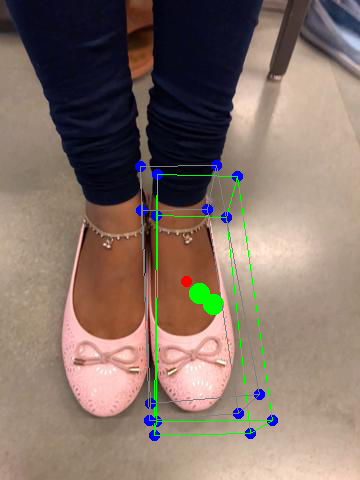

In [4449]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points_3d_result_centered, intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [4450]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [4451]:
def get_bbox_area(bbox):
    dx = bbox[2]-bbox[0]
    dy = bbox[3]-bbox[1]
    return np.sqrt(dx**2+dy**2)
scale = get_bbox_area(query_bbox) / get_bbox_area(result_bbox)
scale

0.9811957116667148

In [4452]:
scale = get_smooth_scale_factor(points_3d_query, points_3d_result_centered, 2)
scale

0.9905978558333575

In [4453]:
def scale_3d_bbox(bbox, factor):
    assert factor>0
    #factor_a = (1+factor)/2
    #factor_b = (1+factor)/2
    center = bbox[0]
    bbox = (bbox-center)*factor + center #/factor_b
    return bbox

In [4454]:
points3d_scaled = snap_to_plane(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, obj_radius = obj_radius*scale)
#points3d_scaled = snap_to_plane(scale_3d_bbox(points_3d_result, scale), plane_normal_query, plane_center_query)
#points3d_scaled = scale_3d_bbox(points_3d_result_centered, scale)
points3d_scaled

array([[ 0.05828033,  0.0205943 , -0.3997364 ],
       [-0.02314088, -0.02868705, -0.4947267 ],
       [ 0.1795908 , -0.02222718, -0.36060398],
       [-0.06466354, -0.02310995, -0.43223225],
       [ 0.13806814, -0.0166501 , -0.29810953],
       [-0.02150749,  0.05783867, -0.50136315],
       [ 0.18122415,  0.06429858, -0.36724032],
       [-0.06303015,  0.0634158 , -0.4388687 ],
       [ 0.13970152,  0.06987565, -0.30474586]])

In [4455]:
#points3d_scaled, points_3d_result, snap_to_plane(points_3d_axis, plane_normal_query, plane_center_query)

In [4456]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.6333373371833251

In [4457]:
def get_scale_factor(points_3d_query, points3d_scaled):
    points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, intrinsics)
    points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
    result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
    query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)
    scale = get_bbox_area(query_bbox) / get_bbox_area(result_bbox)
    return scale
get_scale_factor(points_3d_query, points3d_scaled)

0.9921072223823295

In [4458]:
def get_smooth_scale_factor(points_3d_query, points3d_scaled, alpha):
    factor = get_scale_factor(points_3d_query, points3d_scaled)    
    return (alpha+factor-1)/alpha
get_smooth_scale_factor(points_3d_query, points3d_scaled, 3)

0.9973690741274431

In [4459]:
scale = get_smooth_scale_factor(points_3d_query, points3d_scaled, 2)
for i in range(0,3):
    obj_radius = get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = snap_to_plane(scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, obj_radius = obj_radius*scale)
    scale = get_smooth_scale_factor(points_3d_query, points3d_scaled, 2)
    print(i, obj_radius, scale, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0 0.03761908371025982 0.9983520759048763 0.6308493075424446
1 0.03747062306155379 0.9993133505389142 0.6298071620245322
2 0.03740887320304011 0.9997141492304578 0.6293723776398669


0.6293723776398669

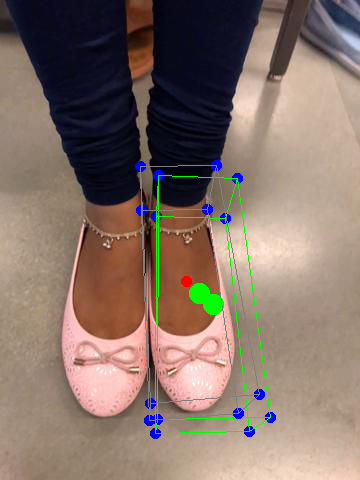

In [4460]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [4461]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()